In [1]:
import tensorflow as tf

import numpy as np

units = 5000
time_steps = 52

# data generating process is translated from jim savage's version!

a_trend = np.arange(0, time_steps, 1)
individual_effects = np.random.normal(size=units)
A_trend = np.tile(a_trend, units).reshape(units, time_steps)
A_indiv = np.tile(individual_effects, time_steps).reshape(time_steps, units).T
A = A_trend + A_indiv

X_observed = []
for row in A.tolist():
    current_row = []
    for val in row:
        val = val if np.random.rand() > 0.1 else np.nan
        current_row.append(val)
    X_observed.append(current_row)
X_observed = np.array(X_observed)

In [6]:
import tensorflow as tf
import numpy as np


class MCNNM(object):
    def __init__(self, num_cores=8, GPU=False, CPU=True, learning_rate=1.):
        self.train_op = None
        self.learning_rate = learning_rate

        # some boilerplate for enabling/disabling GPU
        if GPU:
            num_GPU = 1
            num_CPU = 1
        if CPU:
            num_CPU = 1
            num_GPU = 0

        self.tf_config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
                inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
                device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
        
    def build_tf_graph(self, X, lambd):
        tf.reset_default_graph()
        input_shape = X.shape
        num_observed = float((~np.isnan(X)).sum())
        
        self.observed =  tf.constant((~np.isnan(X)) * 1, dtype=tf.float64)
        X = tf.constant(X, tf.float64)
        self.X_completed_tensor = tf.get_variable("x_completed", 
                                                  input_shape, 
                                                  dtype=tf.float64)
        self.l = self.loss(X, self.X_completed_tensor, num_observed, lambd)
        return tf.train.AdamOptimizer(self.learning_rate).minimize(self.l)
        
    def loss(self, X_observed, X_completed, num_observed, lambd):
        delta = self.project_A(X_observed - X_completed)
        self.normalized_frobenius = tf.norm(delta) / num_observed
        s, _, _ = tf.svd(X_completed)
        self.nuclear_norm = tf.reduce_sum(s)
        return self.normalized_frobenius + lambd * self.nuclear_norm
    
    def project_A(self, A):
        return tf.multiply(tf.where(tf.is_nan(A), tf.zeros_like(A), A), self.observed)
    
    def fit_predict(self, X, lambd=0.0001, iterations=1000, verbose=True):
        self.train_op = self.build_tf_graph(X, lambd)
        with tf.Session(config=self.tf_config) as sess:
            sess.run(tf.global_variables_initializer())
            loss, frob, nn = sess.run([self.l, self.normalized_frobenius, self.nuclear_norm])
            if verbose:
                print("initial loss is {}. Frob norm is {}. NN is {}.".format(loss, frob, nn))
            for i in range(iterations):
                _, loss = sess.run([self.train_op, self.l])
                if i > 0 and i % 100 == 0 and verbose:
                    print("current loss at step {} is: {}".format(i, loss))
            self.X_completed, self.current_loss = sess.run([self.X_completed_tensor, self.l])
            if verbose:
                print("final loss is {}".format(self.current_loss))
            return self.X_completed

    def pick_lambdas(self, start=1, end=-9, count=10, power=True):
        lambdas = np.arange(start, end, (end - start) / float(count))
        if power:
            lambdas = np.power(10, lambdas)
        return lambdas
    
    def get_crossvalidation_loss(self, X_test, X_completed):
        r = [(x_t - x_c)**2. for x_t, x_c in zip(X_test.flatten(), X_completed.flatten()) if not np.isnan(x_t)] 
        r = sum(r) / ((~np.isnan(X_test)).sum())
        return r
        
    def cross_validate(self, X, lambdas=[], folds=5, kwargs={}, verbose=True):
        if len(lambdas) == 0:
            lambdas = self.pick_lambdas()
        results = np.zeros(shape=(folds, len(lambdas)))
        for i in range(folds):
            X_train, X_test = self.split_data(X)
            for j, lambd in enumerate(lambdas):
                X_completed = self.fit_predict(X, lambd=lambd, verbose=False, **kwargs)
                results[i][j] = self.get_crossvalidation_loss(X_test, X_completed)
        results = np.median(results, axis=0)
        if verbose:
            print("lambdas:", lambdas)
            print("Median MSEs:", results)
        best_lambda = lambdas[np.argmin(results)]
        return best_lambda
        
    def split_data(self, X):
        number_observed = (~np.isnan(X_observed)).sum() 
        fraction_observed = number_observed / (X_observed.shape[0]*X_observed.shape[1])
        number_to_select = int(np.ceil(fraction_observed * number_observed))
        selected = np.random.choice(range(number_observed), size=number_to_select, replace=False)

        X_train = []; X_test = []
        for i, row in enumerate(X_observed.tolist()):
            current_train_row = []
            current_test_row = []
            for j, val in enumerate(row):
                if i + j in selected:
                    current_train_row.append(val)
                    current_test_row.append(np.nan)
                else:
                    current_train_row.append(np.nan)
                    current_test_row.append(val)
            X_train.append(current_train_row)
            X_test.append(current_test_row)
        X_train = np.array(X_train)
        X_test = np.array(X_test)
        return X_train, X_test

In [7]:
model = MCNNM()
model.fit_predict(X_observed, iterations=500, lambd=1e-7)

initial loss is 0.061217783099648475. Frob norm is 0.06121048376737203. NN is 72.99332276442651.
current loss at step 100 is: 0.03385654440099862
current loss at step 200 is: 0.0026624741769605944
current loss at step 300 is: 0.0018161797565133951
current loss at step 400 is: 0.0015610925804993951
final loss is 0.0015617183019356355


array([[-1.53635097, -0.53241162,  0.4666322 , ..., 47.47191515,
        48.46528351, 49.45837831],
       [-0.25671383,  0.74574557,  1.70734204, ..., 48.73569856,
        49.73728772, 50.7358575 ],
       [ 0.62897124,  1.64319631,  2.64757711, ..., 49.63582123,
        50.63525461, 51.65707341],
       ...,
       [-2.46721051, -1.47652256, -0.47907954, ..., 46.5183322 ,
        47.52154028, 48.52198505],
       [-1.42512265, -0.43172244,  0.54887283, ..., 47.57060248,
        48.56804265, 49.56963451],
       [ 0.30190312,  1.30677794,  2.29937274, ..., 49.30762759,
        50.29933079, 51.3009217 ]])

In [8]:
lambd = model.cross_validate(X_observed, folds=3, kwargs={'iterations': 500})
lambd

lambdas: [1.e+01 1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08]
Median MSEs: [8.74476848e+02 8.74519463e+02 8.74510827e+02 8.74504882e+02
 8.74482450e+02 8.74466176e+02 8.74319237e+02 3.66621217e-04
 9.10393502e-05 1.10589859e-04]


1e-07

In [9]:
model.fit_predict(X_observed, iterations=1000, lambd=lambd)

initial loss is 0.06128357602487604. Frob norm is 0.061210531446904096. NN is 73.04457797194394.
current loss at step 100 is: 0.0464511584991518
current loss at step 200 is: 0.023976601480258913
current loss at step 300 is: 0.015457361665983767
current loss at step 400 is: 0.015446730855401332
current loss at step 500 is: 0.01544309509180137
current loss at step 600 is: 0.01544212085522212
current loss at step 700 is: 0.015442117787439329
current loss at step 800 is: 0.015442367614257492
current loss at step 900 is: 0.015442718219936577
final loss is 0.015443150405275791


array([[-1.52355107, -0.5372075 ,  0.4659409 , ..., 47.4454591 ,
        48.45111517, 49.44839559],
       [-0.27066193,  0.75124867,  1.74130792, ..., 48.73297055,
        49.72362367, 50.73003127],
       [ 0.62201849,  1.62113617,  2.62492045, ..., 49.62687984,
        50.62424393, 51.62259981],
       ...,
       [-2.45450328, -1.4649343 , -0.45360128, ..., 46.55554822,
        47.47705725, 48.50694786],
       [-1.44075926, -0.40896247,  0.5626034 , ..., 47.53997254,
        48.53994925, 49.55376806],
       [ 0.29568001,  1.26412352,  2.29720692, ..., 49.30814378,
        50.30428848, 51.28134894]])

In [10]:
import pandas as pd
df = pd.DataFrame({'X_observed': X_observed.flatten(), 
                   'X_completed': model.X_completed.flatten(), 
                   'observed': ~np.isnan(X_observed.flatten()), 
                   'a': A.flatten()})

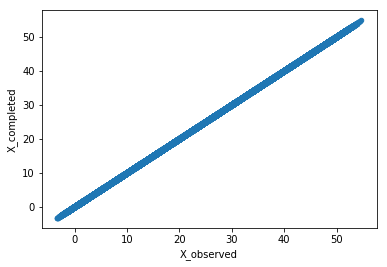

In [11]:
%matplotlib inline

# How well do we fit the training data?

df[df.observed == True].plot(x='X_observed', y='X_completed', kind='scatter')

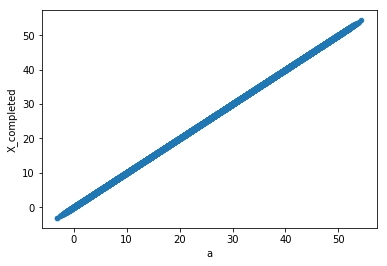

In [12]:
# How well do we complete the matrix on the unobserved entries?

df[df.observed == False].plot(x='a', y='X_completed', kind='scatter')